In [2]:
from __future__ import division, print_function
import uproot4
import uproot
import numpy as np
import pandas as pd
import numba as nb
import scipy.constants
import uproot_methods.convert
import matplotlib.pyplot as plt
import mplhep as hep
from math import *
import sys
import uproot_methods

In [3]:
PATH = '/eos/home-m/matheus/sample_signal/' # caminho onde se encontra as nTuplas
#PATH_PLOT = '/home/matheus/Documentos/4quadri_vertive/plots_signal' # caminho para salvar os plots
SM = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_0.0.root'
ANOMALO1 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_2e-5.root'
ANOMALO2 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_2e-6.root'
ANOMALO3 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_5e-6.root'
ANOMALO4 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_8e-6.root'
ANOMALO5 = 'pre_MiniAOD_FPMC_WW_13TeV_0.5e-6_0.0.root'
ANOMALO6 = 'pre_MiniAOD_FPMC_WW_13TeV_1.0e-6_0.0.root'
ANOMALO7 = 'pre_MiniAOD_FPMC_WW_13TeV_2.0e-6_0.0.root'
ANOMALO8 = 'pre_MiniAOD_FPMC_WW_13TeV_5.0e-6_0.0.root'


 Seção de choque para as amostras de BACKGROUND do Monte Carlo 



In [4]:
cross_section_TT = 831.7
cross_section_inclusive_WZ = 10.73
cross_section_inclusive_WW = 49.997
cross_section_inclusive_ZZ = 3.28
cross_section_ST_s_channel = 3.365
cross_section_ST_t_channel_top = 136.02
cross_section_ST_t_channel_antitop = 80.95
cross_section_ST_tW_top= 35.85
cross_section_ST_tW_antitop = 35.85
cross_section_DYJetsToLL_Pt_100To250 = 83.12
cross_section_DYJetsToLL_Pt_250To400 = 3.047
cross_section_DYJetsToLL_Pt_400To650 = 0.3921
cross_section_DYJetsToLL_Pt_650ToInf = 0.0363
cross_section_QCD_Pt_170to300 = 8654
cross_section_QCD_Pt_300to470 = 797.3
cross_section_QCD_Pt_470to600 = 79.0
cross_section_QCD_Pt_600to800 = 25.09
cross_section_QCD_Pt_800to1000 = 4.7
cross_section_QCD_Pt_1000toInf = 1.6
cross_section_WJetsToLNu_Pt_100To250 = 677.82
cross_section_WJetsToLNu_Pt_WJetsToLNu_Pt_250To400 = 24.083
cross_section_WJetsToLNu_Pt_400To600 = 3.0563
cross_section_WJetsToLNu_Pt_600ToInf = 0.4602

número de eventos para as amostras de BACKGROUND do Monte Carlo 

In [5]:
number_events_TT = 76915549
number_events_inclusive_WZ = 24311445
number_events_inclusive_WW = 6655400 + 1999200
number_events_inclusive_ZZ = 15061141 + 755866
number_events_ST_s_channel = 1000000
number_events_ST_t_channel_top = 43864048
number_events_ST_t_channel_antitop = 38811017
number_events_ST_tW_top = 6952830
number_events_ST_tW_antitop = 6933094
number_events_DYJetsToLL_Pt_100To250 = 76440229 + 2991815 + 2805972 + 2046961
number_events_DYJetsToLL_Pt_250To400 = 47559302 + 594317 + 590806 + 423976
number_events_DYJetsToLL_Pt_400To650 = 604038 + 589842 + 432056
number_events_DYJetsToLL_Pt_650ToInf = 597526 + 430691
number_events_QCD_Pt_170to300 = 19789673 + 7947159 
number_events_QCD_Pt_300to470 = 24605508 + 16462878 + 7937590
number_events_QCD_Pt_470to600 = 9847664 + 5668793 + 3972819
number_events_QCD_Pt_600to800 = 9928218 + 5971175 + 401013
number_events_QCD_Pt_800to1000 = 9966149 + 6011849 + 3962749
number_events_QCD_Pt_1000toInf = 9638102 + 3990117
number_events_WJetsToLNu_Pt_100To250 = 99043287 + 10088599 + 9944879
number_events_WJetsToLNu_Pt_250To400 = 10021205 + 1001250 + 1000132
number_events_WJetsToLNu_Pt_400To600 = 988234 + 951713 
number_events_WJetsToLNu_Pt_600ToInf = 985127 + 989482

 Seção de choque para as amostras de SIGNAL do Monte Carlo 


In [6]:
cross_section_SM       = 40.41*0.17
cross_section_ANOMALO1 = 166.1*0.17 
cross_section_ANOMALO2 = 41.90*0.17
cross_section_ANOMALO3 = 48.75*0.17
cross_section_ANOMALO4 = 61.14*0.17
cross_section_ANOMALO5 = 41.58*0.17
cross_section_ANOMALO6 = 44.93*0.17
cross_section_ANOMALO7 = 58.18*0.17 
cross_section_ANOMALO8 = 150.3*0.17

número de eventos para as amostras de SIGNAL do Monte Carlo 

In [7]:
number_events_SM       = 35000
number_events_ANOMALO1 = 35000
number_events_ANOMALO2 = 35000
number_events_ANOMALO3 = 35000
number_events_ANOMALO4 = 35000
number_events_ANOMALO5 = 35000
number_events_ANOMALO6 = 35000
number_events_ANOMALO7 = 35000
number_events_ANOMALO8 = 35000

Luminosidade dos eventos de dados 


In [8]:
SingleMuon_Run2016B = 4.55
SingleMuon_Run2016C = 1.59
SingleMuon_Run2016G = 3.65
Luminosidade        = SingleMuon_Run2016B + SingleMuon_Run2016C + SingleMuon_Run2016G 

Normalizacao dos eventos de BACKGROUND

In [9]:
norm_TT = ( cross_section_TT + Luminosidade ) / number_events_TT
norm_inclusive_WZ = ( cross_section_inclusive_WZ + Luminosidade ) / number_events_inclusive_WZ
norm_inclusive_ZZ = ( cross_section_inclusive_ZZ + Luminosidade ) / number_events_inclusive_ZZ
norm_inclusive_WW = ( cross_section_inclusive_WW + Luminosidade ) / number_events_inclusive_WW
norm_ST_s_channel = ( cross_section_ST_s_channel + Luminosidade ) / number_events_ST_s_channel
norm_ST_t_channel_top = ( cross_section_ST_t_channel_top + Luminosidade ) / number_events_ST_t_channel_top
norm_ST_t_channel_antitop = ( cross_section_ST_t_channel_antitop + Luminosidade) / number_events_ST_t_channel_antitop
norm_ST_tW_antitop = ( cross_section_ST_tW_antitop + Luminosidade ) / number_events_ST_tW_antitop
norm_ST_tW_top = ( cross_section_ST_tW_top + Luminosidade) / number_events_ST_tW_top
norm_QCD = ( cross_section_QCD_Pt_170to300  + cross_section_QCD_Pt_300to470  + cross_section_QCD_Pt_470to600  + cross_section_QCD_Pt_600to800  + cross_section_QCD_Pt_800to1000 + Luminosidade) / ( number_events_QCD_Pt_170to300 + number_events_QCD_Pt_300to470 + number_events_QCD_Pt_470to600 + number_events_QCD_Pt_600to800 + number_events_QCD_Pt_800to1000 )
norm_DYJetsToLL = ( cross_section_DYJetsToLL_Pt_100To250 + cross_section_DYJetsToLL_Pt_250To400 + cross_section_DYJetsToLL_Pt_400To650 + cross_section_DYJetsToLL_Pt_650ToInf + Luminosidade ) / ( number_events_DYJetsToLL_Pt_100To250 + number_events_DYJetsToLL_Pt_250To400 + number_events_DYJetsToLL_Pt_400To650 + number_events_DYJetsToLL_Pt_650ToInf )

Normalizacao dos eventos de SIGNAL

In [11]:
norm_SM = ( cross_section_SM + Luminosidade ) / ( number_events_SM )
norm_ANOMALO1 = ( cross_section_ANOMALO1 + Luminosidade ) / ( number_events_ANOMALO1 )
norm_ANOMALO2 = ( cross_section_ANOMALO2 + Luminosidade ) / ( number_events_ANOMALO2 )
norm_ANOMALO3 = ( cross_section_ANOMALO3 + Luminosidade ) / ( number_events_ANOMALO3 )
norm_ANOMALO4 = ( cross_section_ANOMALO4 + Luminosidade ) / ( number_events_ANOMALO4 )
norm_ANOMALO5 = ( cross_section_ANOMALO5 + Luminosidade ) / ( number_events_ANOMALO5 )
norm_ANOMALO6 = ( cross_section_ANOMALO6 + Luminosidade ) / ( number_events_ANOMALO6 )
norm_ANOMALO7 = ( cross_section_ANOMALO7 + Luminosidade ) / ( number_events_ANOMALO7 )
norm_ANOMALO8 = ( cross_section_ANOMALO8 + Luminosidade ) / ( number_events_ANOMALO8 )

Criando uma função que ler as nTuplas com o uproot e retorna a tree. Se quiser ver todos os branchs, descomenta a parte em que está print(tree_.show())

In [12]:
def open_files( file ): # Funcao que ler e abre as trees das nTuplas
    #print( file )
    root_ = uproot.open( file ) # abertura dos arquivos 
    tree_ = root_[ "demo/Events" ] # trees das nTupla
    #print( tree_.show() ) # printar na tela todos os branches da nTupla
    return tree_

Abrindo cada tree dos arquivos correspondentes ao modelo padrão e dos acoplamentos anômalos

In [13]:
tree_SM       = open_files( PATH + SM )
tree_ANOMALO1 = open_files( PATH + ANOMALO1 )
tree_ANOMALO2 = open_files( PATH + ANOMALO2 )
tree_ANOMALO3 = open_files( PATH + ANOMALO3 )
tree_ANOMALO4 = open_files( PATH + ANOMALO4 )
tree_ANOMALO5 = open_files( PATH + ANOMALO5 )
tree_ANOMALO6 = open_files( PATH + ANOMALO6 )
tree_ANOMALO7 = open_files( PATH + ANOMALO7 )
tree_ANOMALO8 = open_files( PATH + ANOMALO8 )

A função abaixo ( get_branche ) vai retornar um array do branche escolhido, por exemplo muon_pt, jetAK8_pt, jetAK8_prunedMass e etc.

In [14]:
def get_branche( tree , array ):
    branche = pd.DataFrame( tree.array( array ) )[0] # primeira coluna do formato DataFrame de qualquer branche
    return branche

A função almir, dedicado ao meu vizinho velho que vem beber café toda tarde comigo, calcula as principais variáveis, como a massa reconstruida do WW, o momento transverso (Pt) do W leptônico, e o DeltaPhi entre jatos/MET e W_leptônico/W_hadrônico. Para fazer tais calculos, eu utilizo o TLorentzVector atribuida ao Python, que está inserida no uproot_methods, biblioteca está que é importarda na primeira célula.
A massa reconstruida do WW é a mais difícil, pois precisa da componente z do momento do neutrino. As equações usadas são.

 $k = \dfrac{m_{\text{w}}^{2}}{2} + \mathbf{P}^{T}_{\mu} \cdot \mathbf{P}^{T}_{\nu}$

$ p_{\nu}^{z} = \dfrac{k \cdot p_{\mu}^{z}}{p_{\mu}^{T2}} \pm \sqrt{ \dfrac{k^{2} \cdot p_{\mu}^{z2}}{p_{\mu}^{T4} } - \dfrac{E^{2}_{\mu}E_{miss}^{T2}}{p_{\mu}^{T2}} - k }$

Temos que tomar cuidado com a raiz negativa, neste caso, como estou trabalhando com DataFrame, o resultado de uma raiz imaginária vai ser NaN, usando o .dropna(0) no DataFrame, ele substitui o valor NaN por 0 e com isso eu consigo a parte real da minha expressão

In [16]:
def almir( tree ): # Funcao que retorna um DataFrame que contem a massa invariante do WW, pt do par de le
    Mw = 80.379 # massa do boson W
    k = ( ( Mw**2 ) / 2 + get_branche(tree,'muon_px')*get_branche(tree,'METPx')) + (get_branche(tree,'muon_py')*get_branche(tree,'METPy') ) 
    raiz = ( ( ( (k * get_branche(tree,'muon_pz'))**2) / (get_branche(tree,'muon_pt')**4)  - ( (get_branche(tree,'muon_E')*get_branche(tree,'METPt'))**2 - k)/get_branche(tree,'muon_pt')**2)**0.5 ).fillna(0) # O .fillna(0) substitui os NaN's  por 0 no DataFrame que apresentam raiz imaginaria
    Pz_nu = ( ( k*get_branche(tree,'muon_pz') / (get_branche(tree,'muon_pt')**2 ) ) + raiz ) # coordenada z do momentum do neutrino reconstruido
    W_lep_energy = get_branche(tree,'muon_E') + (get_branche(tree,'METPx')**2 + get_branche(tree,'METPy')**2 + Pz_nu**2)**0.5 # Energia do par de léptons  
    TLV_lep = uproot_methods.TLorentzVectorArray(get_branche(tree,'muon_px')+get_branche(tree,'METPx'),get_branche(tree,'muon_py')+get_branche(tree,'METPy'),get_branche(tree,'muon_pz')+ Pz_nu,W_lep_energy) # 4-vector do par de lepton
    TLV_jet = uproot_methods.TLorentzVectorArray(get_branche(tree,'jetAK8_px'),get_branche(tree,'jetAK8_py'),get_branche(tree,'jetAK8_pz'),get_branche(tree,'jetAK8_E'))
    W_mass = ( TLV_lep + TLV_jet ).mass # Massa invariante do WW
    W_lep_pt = ( TLV_lep ).pt # Pt do par de lepton
    dphi_jet_lep = TLV_lep.phi - TLV_jet.phi
    dphi_jet_lep = np.where( dphi_jet_lep >=  scipy.constants.pi, dphi_jet_lep - 2*scipy.constants.pi, dphi_jet_lep)
    dphi_jet_lep = np.where( dphi_jet_lep <  -scipy.constants.pi, dphi_jet_lep + 2*scipy.constants.pi, dphi_jet_lep) # delta phi entre o jato e o par de lepton
    dphi_jet_MET = get_branche(tree,'METphi') - TLV_jet.phi
    dphi_jet_MET = np.where( dphi_jet_MET >=  scipy.constants.pi, dphi_jet_MET - 2*scipy.constants.pi, dphi_jet_MET)
    dphi_jet_MET = np.where( dphi_jet_MET <  -scipy.constants.pi, dphi_jet_MET + 2*scipy.constants.pi, dphi_jet_MET) # delta phi entre o jato e o MET 
    #acopl = (1. - np.abs(dphi)/scipy.constants.pi) 
    DataFrame = pd.DataFrame(pd.concat([pd.DataFrame(W_mass,columns=['Mass_WW']),pd.DataFrame(W_lep_pt,columns = ["W_lep_Pt"]),pd.DataFrame(dphi_jet_lep,columns=['Dphi_jet_lep']),pd.DataFrame(dphi_jet_MET,columns=['Dphi_jet_MET'])],axis=1))  
    return DataFrame

Agora uma função genérica que monta os histogramas.
Aqui vale uma observação --> eu usei 2 plots para cada variável (branche). Como estou com muita amostra de sinal ( 8 anômalos + 1 SM ), se fosse fazer em um apenas, estaria muito poluído, então resolvi separar em dois, mantendo o modelo padrão em cada, porém, um plot tem os valores anômalos de Alpha0 e o outro de AlphaC.

In [35]:
def plot(lista_1,lista_2,bins0,bins1,label0,label1,fontsize_leg,xmin,xmax,xlabel,ylabel,fontsize_xlabel,fontsize_ylabel,loc_leg,lista_norm1,lista_norm2):
    fig, axes = plt.subplots( 1, 2, figsize=(20,11) )
    axes[0].hist( lista_1, bins = bins0, stacked=False, histtype = 'step', label=label0, density = False, weights = lista_norm1, color = ['cyan', 'green', 'red', 'fuchsia','gold'] )
    axes[0].legend(loc=loc_leg, fontsize=fontsize_leg)
    axes[0].set_xlim(xmin,xmax)
    axes[0].set_ylabel(ylabel, fontsize = fontsize_ylabel)
    axes[0].set_yscale('log')
    #axes[0] = hep.cms.cmslabel(data=False, paper=False, year='$9.792 fb^{-1}$', ax = axes[0])

    axes[1].hist( lista_2, bins = bins1, stacked=False, histtype = 'step', label=label1, density = False, weights = lista_norm2, color = ['cyan', 'green', 'red', 'fuchsia','gold'] )
    axes[1].legend(loc=loc_leg, fontsize=fontsize_leg)
    axes[1].set_xlim(xmin,xmax)
    axes[1].set_xlabel(xlabel,fontsize = fontsize_xlabel)
    axes[1].set_yscale('log')
    #axes[1] = hep.cms.cmslabel(data=False, paper=False, year='$9.792 fb^{-1}$', ax = axes[1])    
    #plt.savefig(PATH_PLOT+'/{}.pdf'.format(name))
    plt.show()

Os labels, 0 e 1 são as legendas que entraram na identificação dos histogramas

In [18]:
label_0 = [
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=0.0$ (SM)',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-5}$',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-6}$',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=5 \times 10^{-6}$', 
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$'
          ]

label_1 = [
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.0$ (SM)',  
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.5 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 1.0 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $'
          ]    

Aqui eu aplico a função almir em cada acoplamento anômalo e no SM

In [19]:
DataFrame_SM       = almir(tree_SM)
DataFrame_ANOMALO1 = almir(tree_ANOMALO1)
DataFrame_ANOMALO2 = almir(tree_ANOMALO2)
DataFrame_ANOMALO3 = almir(tree_ANOMALO3)
DataFrame_ANOMALO4 = almir(tree_ANOMALO4)
DataFrame_ANOMALO5 = almir(tree_ANOMALO5)
DataFrame_ANOMALO6 = almir(tree_ANOMALO6)
DataFrame_ANOMALO7 = almir(tree_ANOMALO7)
DataFrame_ANOMALO8 = almir(tree_ANOMALO8)

/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: invalid value encountered in less
/usr/local/bin/start_ipykernel.py:16: RuntimeWarning: invalid value encountered in less


# Grafico jetAK8 Pt 

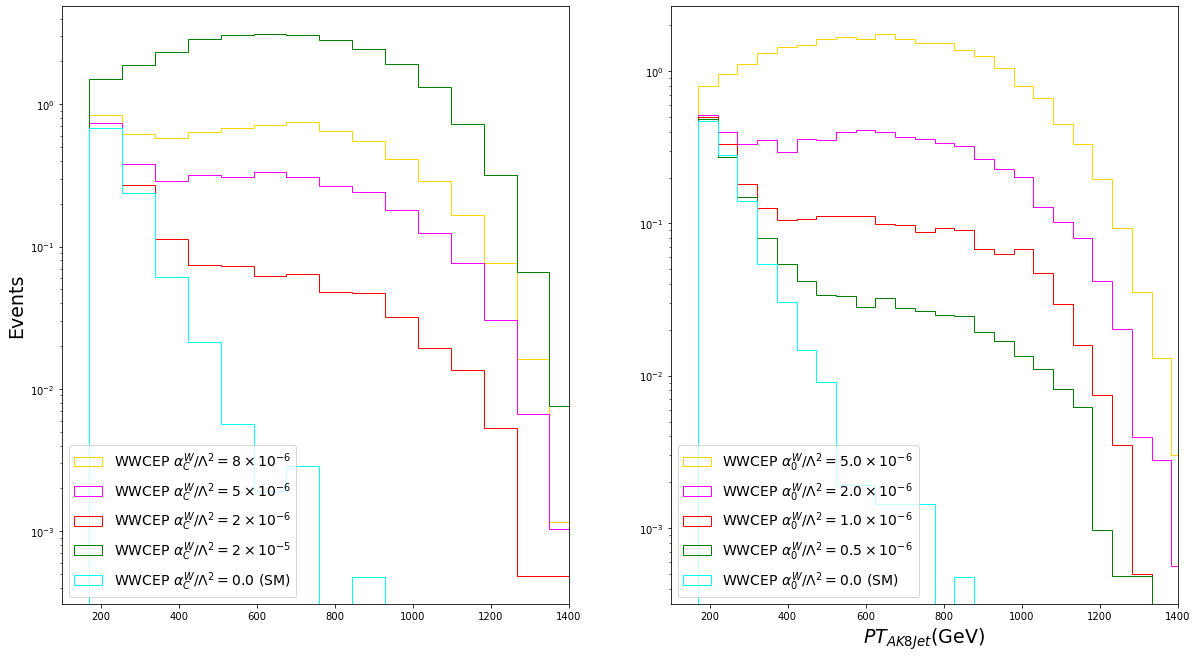

In [33]:
jetAK8_pt_0 = [
get_branche(tree_SM, 'jetAK8_pt'),
get_branche(tree_ANOMALO1, 'jetAK8_pt'),
get_branche(tree_ANOMALO2,'jetAK8_pt'),
get_branche(tree_ANOMALO3,'jetAK8_pt'),
get_branche(tree_ANOMALO4,'jetAK8_pt')
]
jetAK8_pt_1 = [
get_branche(tree_SM, 'jetAK8_pt'),
get_branche(tree_ANOMALO5,'jetAK8_pt'),
get_branche(tree_ANOMALO6,'jetAK8_pt'),
get_branche(tree_ANOMALO7,'jetAK8_pt'),
get_branche(tree_ANOMALO8,'jetAK8_pt')
]

lista_norm_signal_1 = [[norm_SM]*len(jetAK8_pt_0[0]),[norm_ANOMALO1]*len(jetAK8_pt_0[1]),[norm_ANOMALO2]*len(jetAK8_pt_0[2]),[norm_ANOMALO3]*len(jetAK8_pt_0[3]),[norm_ANOMALO4]*len(jetAK8_pt_0[4])]
lista_norm_signal_2 = [[norm_SM]*len(jetAK8_pt_1[0]),[norm_ANOMALO5]*len(jetAK8_pt_1[1]),[norm_ANOMALO6]*len(jetAK8_pt_1[2]),[norm_ANOMALO7]*len(jetAK8_pt_1[3]),[norm_ANOMALO8]*len(jetAK8_pt_1[4])]


plot(jetAK8_pt_0,jetAK8_pt_1,140,140,label_0,label_1,14,100,1400,r'$PT_{AK8Jet}$(GeV)','Events',19,19,'lower left',lista_norm_signal_1,lista_norm_signal_2)

# Grafico Mww --> massa reconstruída do WW

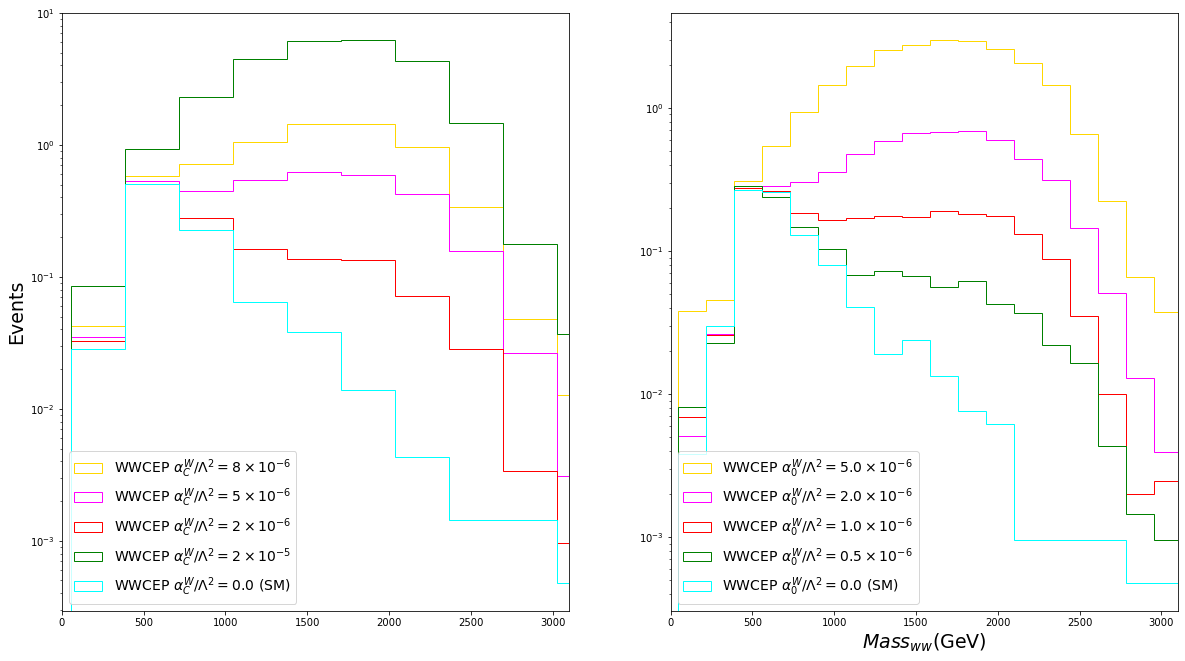

In [59]:
Mww_0 = [ 
DataFrame_SM['Mass_WW'], 
DataFrame_ANOMALO1['Mass_WW'], 
DataFrame_ANOMALO2['Mass_WW'], 
DataFrame_ANOMALO3['Mass_WW'], 
DataFrame_ANOMALO4['Mass_WW']
]
Mww_1 = [ 
DataFrame_SM['Mass_WW'], 
DataFrame_ANOMALO5['Mass_WW'], 
DataFrame_ANOMALO6['Mass_WW'], 
DataFrame_ANOMALO7['Mass_WW'], 
DataFrame_ANOMALO8['Mass_WW']
]

plot(Mww_0,Mww_1,140,140,label_0,label_1,14,0,3100,r'$Mass_{ww}$(GeV)','Events',19,19,'lower left',lista_norm_signal_1,lista_norm_signal_2)

# Grafico Pt do W leptônico

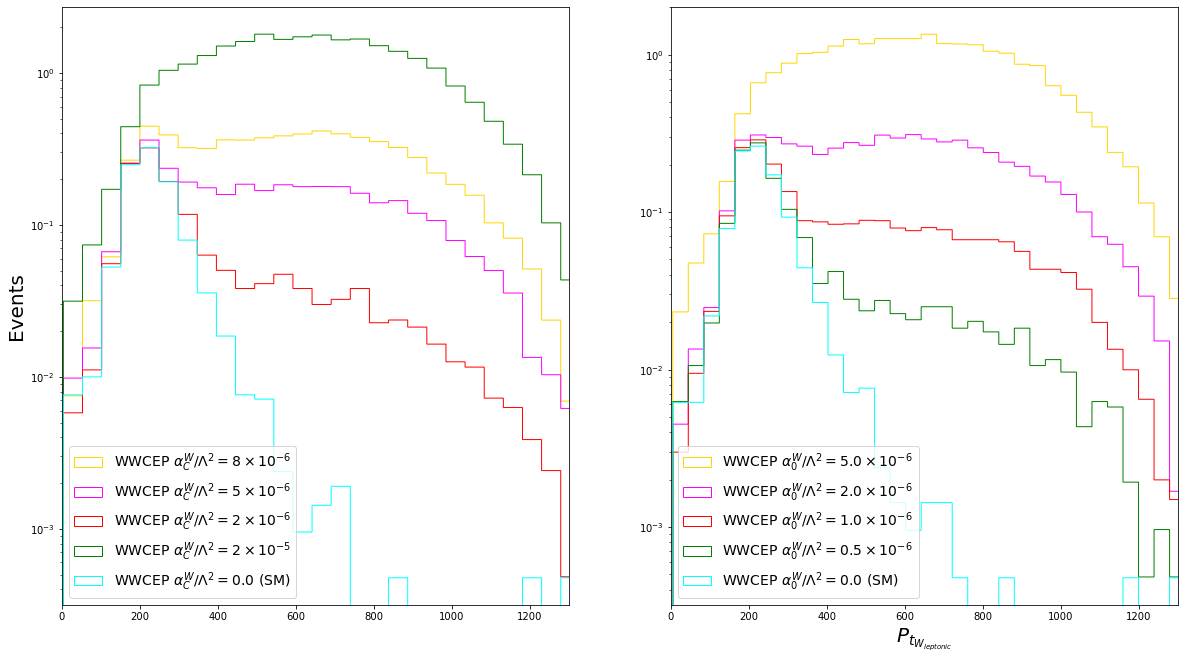

In [58]:
W_lep_Pt_0 = [ 
DataFrame_SM['W_lep_Pt'], 
DataFrame_ANOMALO1['W_lep_Pt'], 
DataFrame_ANOMALO2['W_lep_Pt'], 
DataFrame_ANOMALO3['W_lep_Pt'], 
DataFrame_ANOMALO4['W_lep_Pt']
]
W_lep_Pt_1 = [ 
DataFrame_SM['W_lep_Pt'], 
DataFrame_ANOMALO5['W_lep_Pt'], 
DataFrame_ANOMALO6['W_lep_Pt'], 
DataFrame_ANOMALO7['W_lep_Pt'], 
DataFrame_ANOMALO8['W_lep_Pt']
]

plot(W_lep_Pt_0,W_lep_Pt_1,2000,1000,label_0,label_1,14,0,1300,r'$P_{t_{W_{leptonic}}}$','Events',20,20,'lower left',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico $\Delta \phi (W_{leptônico},W_{hadrônico})$

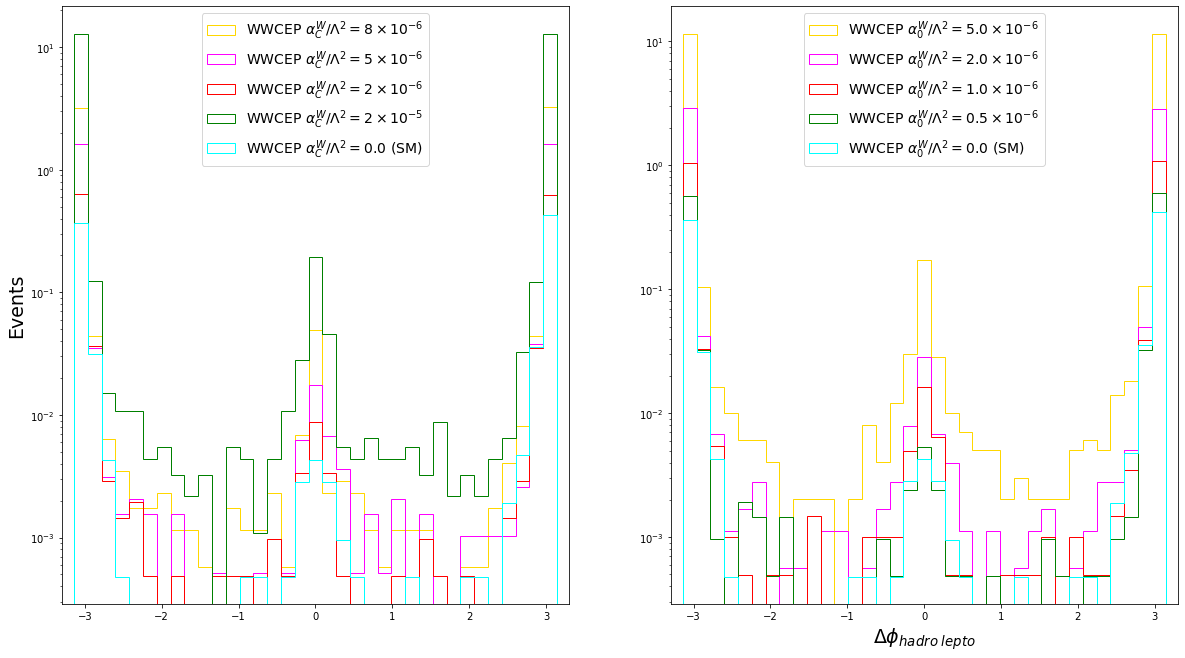

In [42]:

Dphi_jet_lep_0 = [ 
DataFrame_SM['Dphi_jet_lep'], 
DataFrame_ANOMALO1['Dphi_jet_lep'], 
DataFrame_ANOMALO2['Dphi_jet_lep'], 
DataFrame_ANOMALO3['Dphi_jet_lep'], 
DataFrame_ANOMALO4['Dphi_jet_lep']
]
Dphi_jet_lep_1 = [ 
DataFrame_SM['Dphi_jet_lep'], 
DataFrame_ANOMALO5['Dphi_jet_lep'], 
DataFrame_ANOMALO6['Dphi_jet_lep'], 
DataFrame_ANOMALO7['Dphi_jet_lep'], 
DataFrame_ANOMALO8['Dphi_jet_lep']
]

plot(Dphi_jet_lep_0,Dphi_jet_lep_1,35,35,label_0,label_1,14,-3.3,3.3,r'$\Delta \phi_{hadro\;lepto}$','Events',19,19,'upper center',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico $\Delta \phi (Jato,MET)$

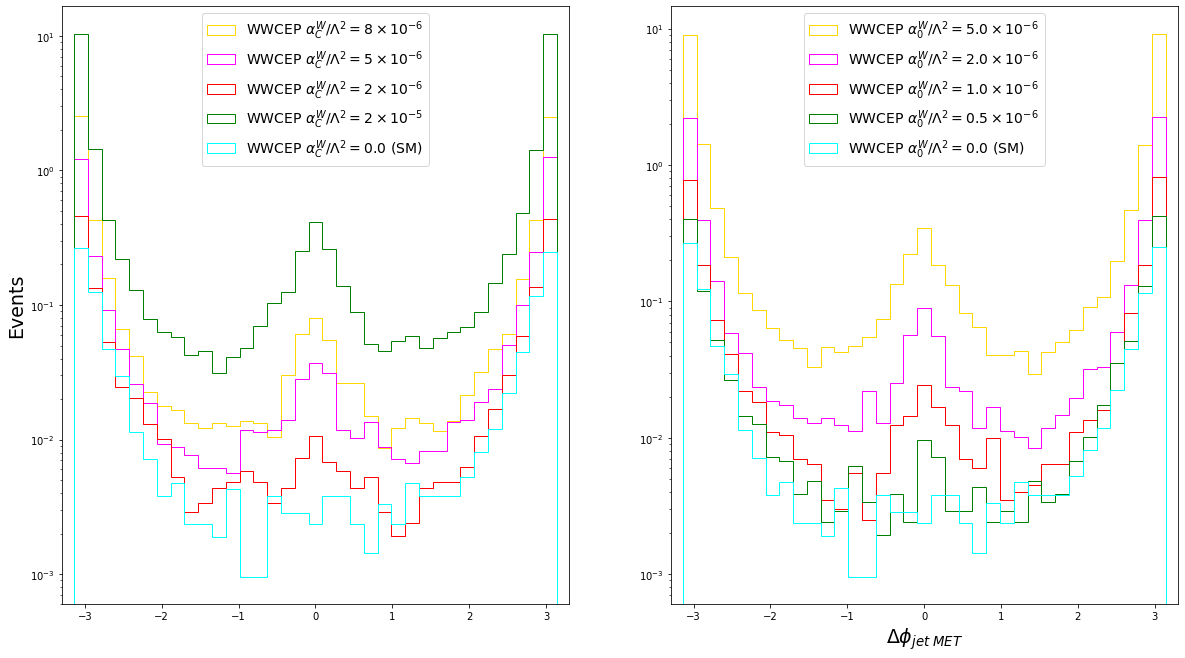

In [57]:
Dphi_jet_MET_0 = [ 
DataFrame_SM['Dphi_jet_MET'], 
DataFrame_ANOMALO1['Dphi_jet_MET'], 
DataFrame_ANOMALO2['Dphi_jet_MET'], 
DataFrame_ANOMALO3['Dphi_jet_MET'], 
DataFrame_ANOMALO4['Dphi_jet_MET']
]
Dphi_jet_MET_1 = [ 
DataFrame_SM['Dphi_jet_MET'], 
DataFrame_ANOMALO5['Dphi_jet_MET'], 
DataFrame_ANOMALO6['Dphi_jet_MET'], 
DataFrame_ANOMALO7['Dphi_jet_MET'], 
DataFrame_ANOMALO8['Dphi_jet_MET']
]

plot(Dphi_jet_MET_0,Dphi_jet_MET_1,35,35,label_0,label_1,14,-3.3,3.3,r'$\Delta \phi_{jet\;MET}$','Events',19,19,'upper center',lista_norm_signal_1,lista_norm_signal_2)


# Grafico jetAK8 prunedMass

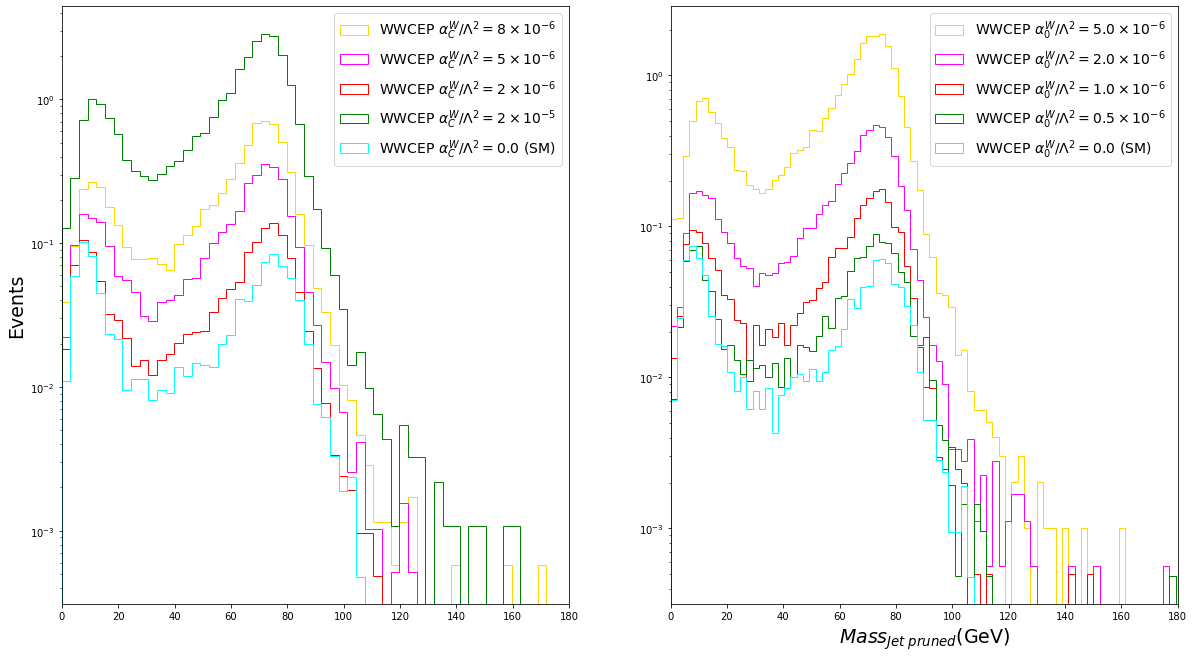

In [45]:
jetAK8_prunedMass_0 = [
get_branche(tree_SM, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO1, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO2, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO3, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO4, 'jetAK8_prunedMass')
]
jetAK8_prunedMass_1 = [
get_branche(tree_SM, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO5, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO6, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO7, 'jetAK8_prunedMass'),
get_branche(tree_ANOMALO8, 'jetAK8_prunedMass')
]

plot(jetAK8_prunedMass_0,jetAK8_prunedMass_1,80,80,label_0,label_1,14,0,180,r'$Mass_{Jet\;pruned}$(GeV)','Events',19,19,'best',lista_norm_signal_1,lista_norm_signal_2)


# Grafico jetAK8 tau21

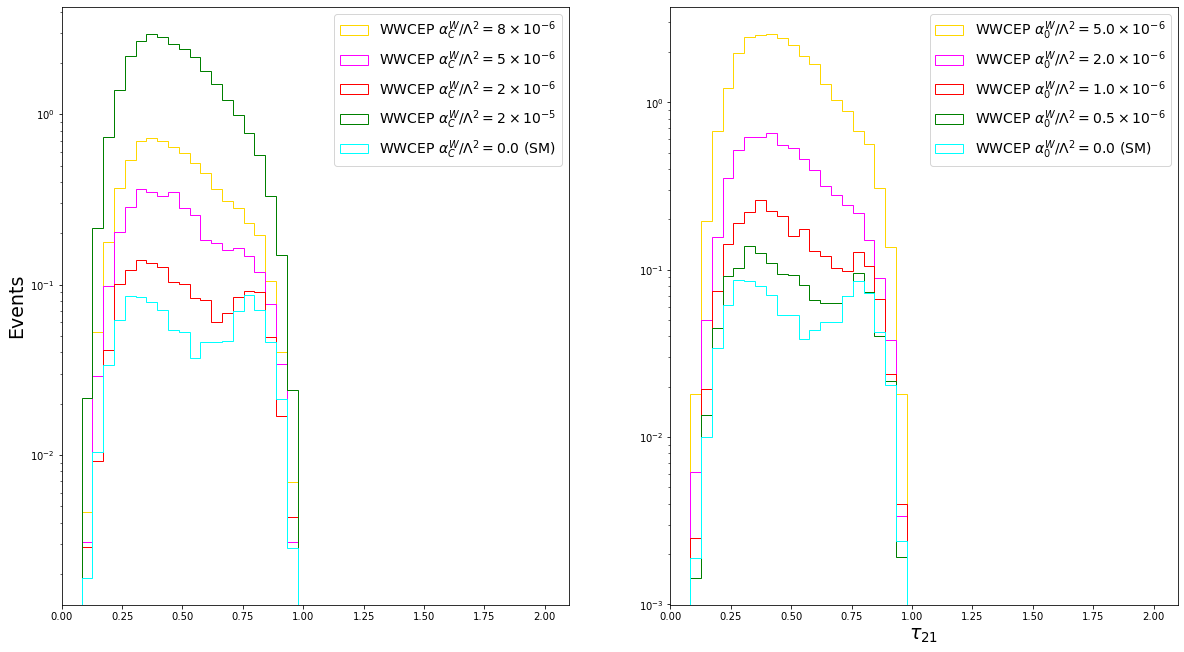

In [48]:
jetAK8_tau21_0 = [
get_branche(tree_SM, 'jetAK8_tau21'),
get_branche(tree_ANOMALO1, 'jetAK8_tau21'),
get_branche(tree_ANOMALO2, 'jetAK8_tau21'),
get_branche(tree_ANOMALO3, 'jetAK8_tau21'),
get_branche(tree_ANOMALO4, 'jetAK8_tau21')
]
jetAK8_tau21_1 = [
get_branche(tree_SM, 'jetAK8_tau21'),
get_branche(tree_ANOMALO5, 'jetAK8_tau21'),
get_branche(tree_ANOMALO6, 'jetAK8_tau21'),
get_branche(tree_ANOMALO7, 'jetAK8_tau21'),
get_branche(tree_ANOMALO8, 'jetAK8_tau21')
]

plot(jetAK8_tau21_0,jetAK8_tau21_1,20,20,label_0,label_1,14,0,2.1,r'$\tau_{21}$','Events',19,19,'best',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico METPt

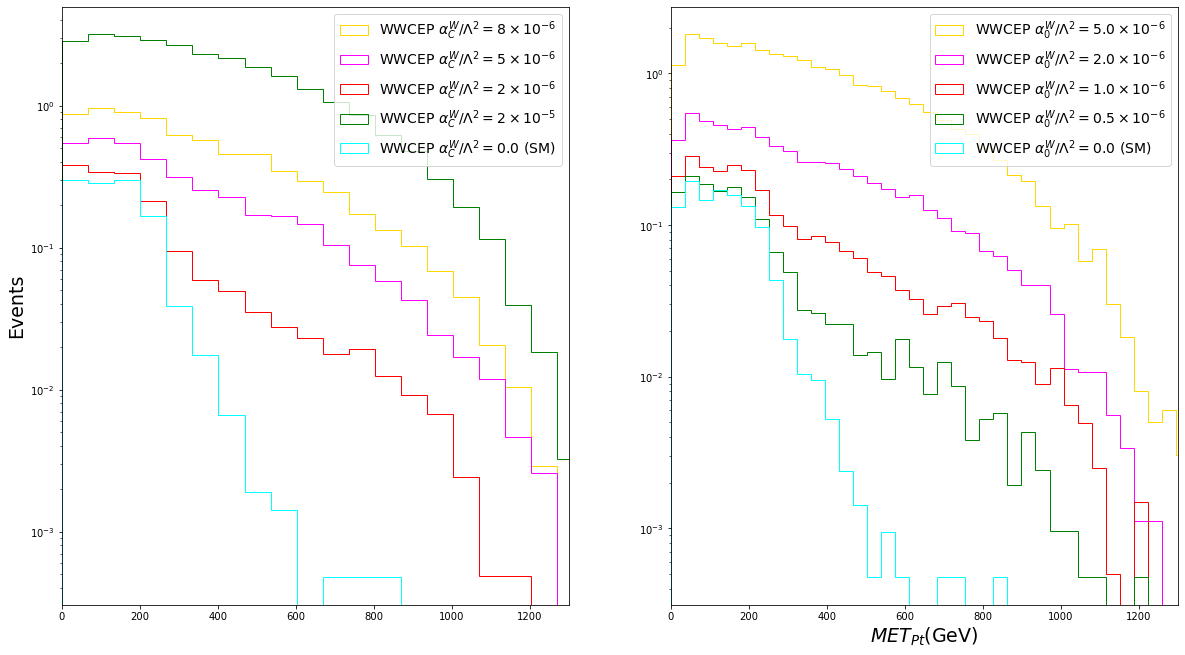

In [52]:
METPt_0 = [
get_branche(tree_SM, 'METPt'),
get_branche(tree_ANOMALO1, 'METPt'),
get_branche(tree_ANOMALO2, 'METPt'),
get_branche(tree_ANOMALO3, 'METPt'),
get_branche(tree_ANOMALO4, 'METPt')
]
METPt_1 = [
get_branche(tree_SM, 'METPt'),
get_branche(tree_ANOMALO5, 'METPt'),
get_branche(tree_ANOMALO6, 'METPt'),
get_branche(tree_ANOMALO7, 'METPt'),
get_branche(tree_ANOMALO8, 'METPt')
]

plot(METPt_0,METPt_1,180,180,label_0,label_1,14,0,1300,r'$MET_{Pt}$(GeV)','Events',19,19,'upper right',lista_norm_signal_1,lista_norm_signal_2)

# Grafico muon pt

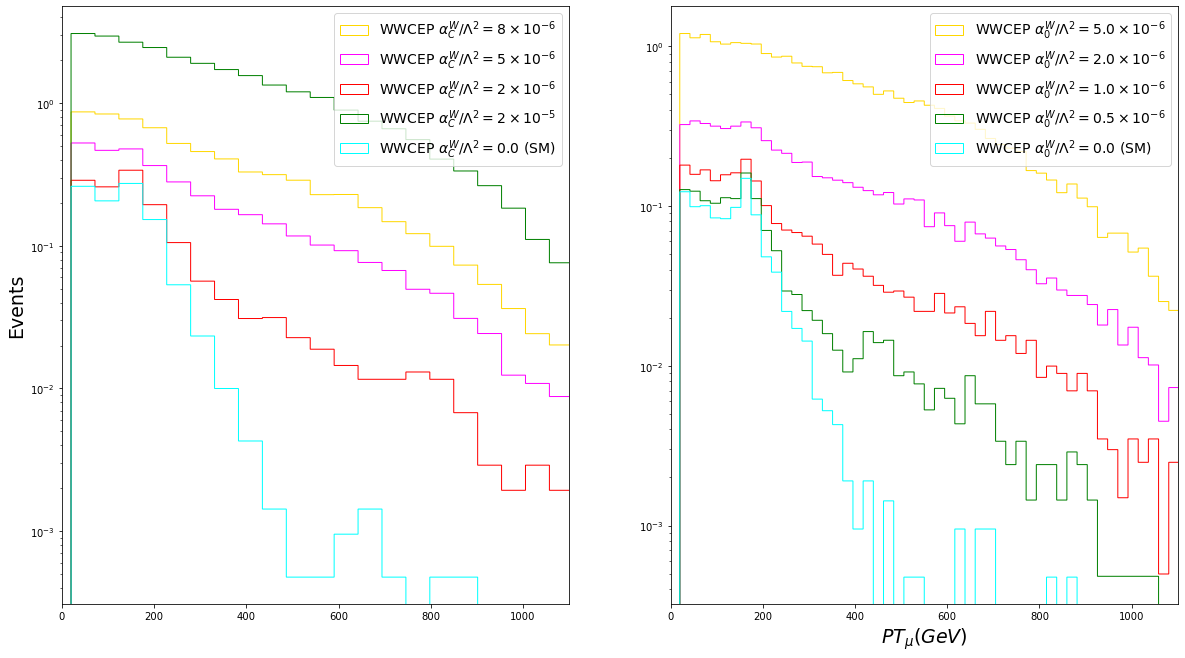

In [56]:
muon_pt_0 = [
get_branche(tree_SM, 'muon_pt'),
get_branche(tree_ANOMALO1, 'muon_pt'),
get_branche(tree_ANOMALO2, 'muon_pt'),
get_branche(tree_ANOMALO3, 'muon_pt'),
get_branche(tree_ANOMALO4, 'muon_pt')
]
muon_pt_1 = [
get_branche(tree_SM, 'muon_pt'),
get_branche(tree_ANOMALO5, 'muon_pt'),
get_branche(tree_ANOMALO6, 'muon_pt'),
get_branche(tree_ANOMALO7, 'muon_pt'),
get_branche(tree_ANOMALO8, 'muon_pt')
]

plot(muon_pt_0,muon_pt_1,1900,1800,label_0,label_1,14,0,1100,r'$PT_{\mu}(GeV)$','Events',19,19,'upper right',lista_norm_signal_1,lista_norm_signal_2)